# Importing Packages

In [44]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Reading a json file into a pandas dataframe

In [45]:
df = pd.read_json(r'E:/Data Science/logins.json')

In [46]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


# Part 1 ‑ Exploratory data analysis


# Converted data frame into datetime object, and set it as the index

In [47]:
df['login_count'] = 1
df = df.set_index(pd.to_datetime(df['login_time'], unit='s'))[['login_count']]

In [48]:
df.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


# Aggregating login counts based on 15 minute time intervals

* Resampling the index, so that time is represented in 15min chunks

In [49]:
df_15min = df.resample('15Min').sum()

In [50]:
df_15min.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [51]:
df_15min.columns

Index(['login_count'], dtype='object')

# Visualizing the data

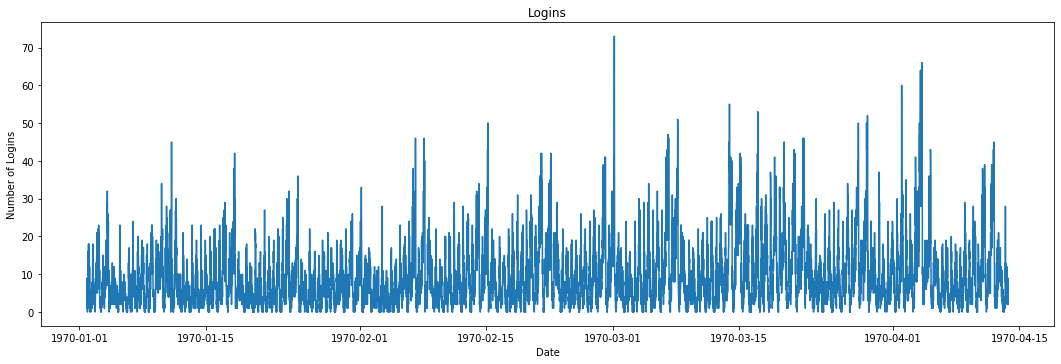

In [52]:
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Date')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
plt.plot(df_15min.index, df_15min.login_count)

From the above visualization, its hard to see any patterns and analize so need to eloborate the above graph

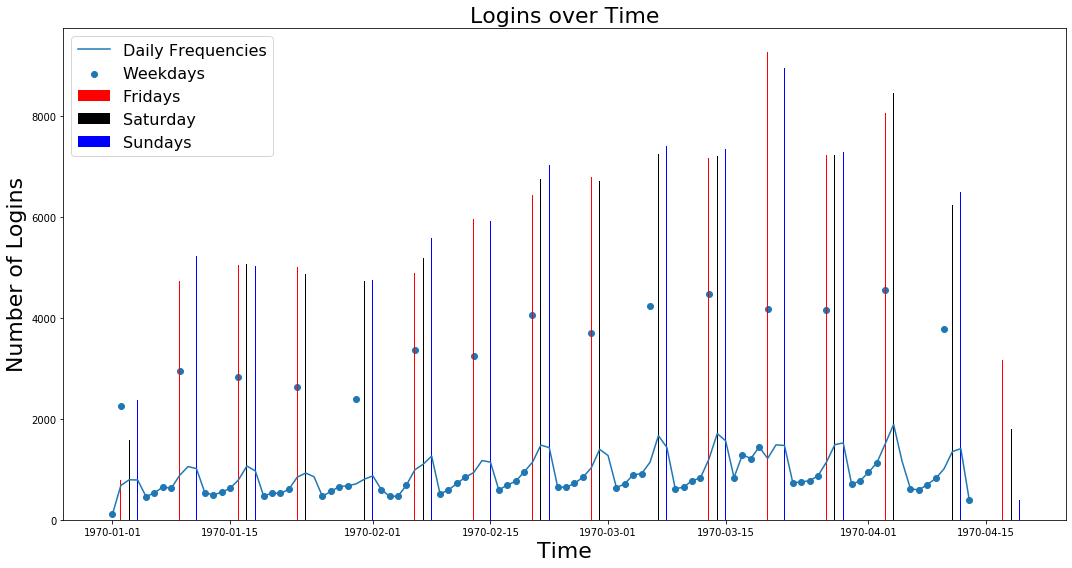

In [53]:
# data by the day
df_daily = df.resample('D').sum()
df_biz_day = df.resample('B').sum()
fridays = df.resample('W-FRI').sum()
saturdays = df.resample('W-SAT').sum()
sundays = df.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'R')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'B')
plt.plot(df_daily.index, df_daily.login_count, label = 'Daily Frequencies')
plt.scatter(df_biz_day.index, df_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

# Part 2 ‑ Experiment and metrics design

There is an electronic record of the number of cars that use the bridge. This is a reasonable assumption, as to reimburse the partner drivers, the drivers would need a record of crossing.

There is historical data on bridge use
The key metric I would use is change in weekday activity. Specifically, during the daytime hours on weekdays, is there an increase of cars entering the bridge from Gotham and during the night, is there an increase of cars entering the bridge from Metropolis.

In order to answer the above questions I would use two hypothesis tests.

H0: There is no difference between the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H2: There is an INCREASE in the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H0: There is no difference between the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 4 am, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H2: There is an INCREASE in the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 4 am, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

I would use a one-tailed Z-test to determine the p-value of each hypothesis.

If the p-value is less than 0.05 for BOTH tests I would reject the null hypotheses and recommend the reimbursement program continue, that the study should be repeated in a year with more data.

If the p-value is greater than 0.05 for BOTH tests I would fail to reject the null hypotheses and recommend that a different program be developed to increase partner driving between the two cities.

If the p-value is mixed, so only one hypothesis has a p-value less than 0.05 I would recommend that the analysis is inconclusive and that further investigation is needed.

# Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. we have
dataset of users who signed up for an Ultimate account in

In [54]:
df1 = pd.read_json(r'E:/Data Science/ultimate_data_challenge.json')
user_data = pd.DataFrame(df1)

# Convert dates to datetime objects

In [55]:
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

In [56]:
# find the date the data was pulled
pull_date = user_data.last_trip_date.max()
# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])

# separate the active and inactive users

In [57]:
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

# calculate the mean and standard deviation for each feature

In [58]:
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

# Creating a dataframe of the statistics

In [59]:
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

In [60]:
stats_df.head()

,active_mean,active_std,inactive_mean,inactive_std
avg_dist,5.118977,4.627946,6.188478,6.213027
avg_rating_by_driver,4.763121,0.324566,4.786876,0.503869
avg_rating_of_driver,4.593364,0.538166,4.607018,0.664816
avg_surge,1.073720,0.163183,1.075367,0.250219
surge_pct,9.128165,15.489344,8.688548,22.132211


Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

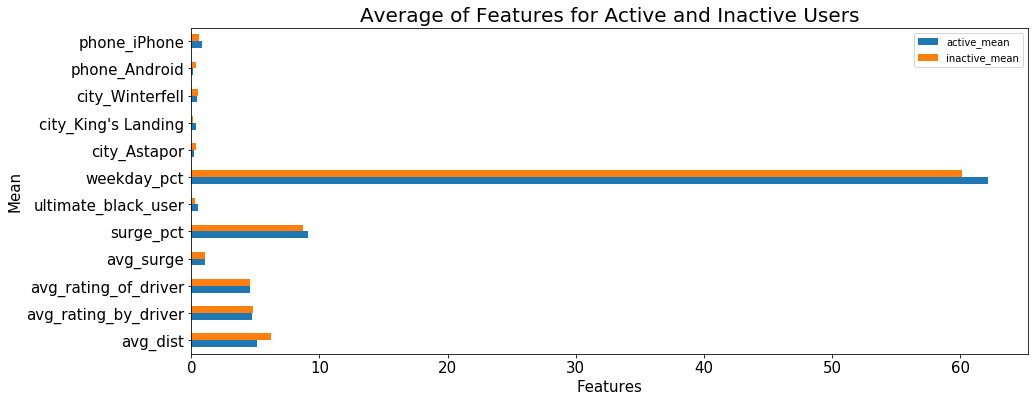

In [61]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'barh', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 15)
plt.ylabel('Mean', fontsize = 15)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)

In [62]:
user_data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0


In [63]:
# define features and target
user_data.dropna(inplace=True)

# Since this is a classification problem, implementing Logistic Regression

In [64]:
X = user_data[feature_columns]
y = user_data.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [65]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
model = LogisticRegression()
model.fit(X_train,y_train)

C:\Users\jayan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
# predict the labels
y_pred = model.predict(X_test)
# score model
score = model.score(X_test,y_test)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(score*100,'%'))

The resulting accuracy of the optimized classifier is 69.22708399872245.


In [67]:
#Setting up the hyper parameter grid space
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
#Instantiate a logistic regression classifier
model1 = LogisticRegression()
#Instantiate the GridSearchCV object
model1_cv = GridSearchCV(model1, param_grid, cv=3)
#Fitting to data
model1_cv.fit(X_train,y_train)
print("Tuned Logistic Regression Parameters : {}".format(model1_cv.best_params_))
print("Best Score is : {}".format(model1_cv.best_score_*100), '%')

C:\Users\jayan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jayan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Tuned Logistic Regression Parameters : {'C': 0.006105402296585327}
Best Score is : 69.5927446954141 %


C:\Users\jayan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\jayan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

# Imlplementing Random Forests

In [68]:
X = user_data[feature_columns]
y = user_data.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)
model2 = RandomForestClassifier()
model2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [69]:
y_pred = model2.predict(X_test)
score2 = model2.score(X_test,y_test)

In [70]:
print("The resulting accuracy of the optimized classifier is {}.".format(score2*100,'%'))

The resulting accuracy of the optimized classifier is 73.77834557649314.


In [78]:
user_data.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0


Text(0.5, 0, 'Relative Importance')

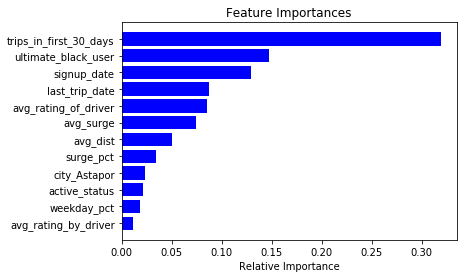

In [79]:
features = user_data.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12]]
importances = model2.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# CONCLUSION

Using Random Forest classifier we got the accuracy of around 74% for the test data which is 
resonably better than Logistic Regression's 69%

The factors that most heavily influence rider retention are the trip in 1st 30 days in miles per trip taken in the first 30 days